Raggio: 8 px | Flusso: 839699.84 | Errore: 960.56 | S/N: 874.18


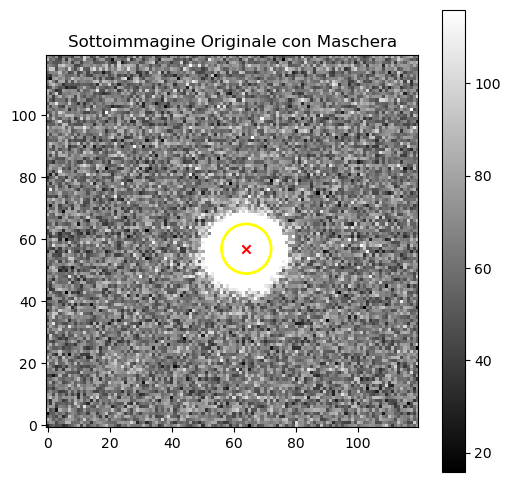

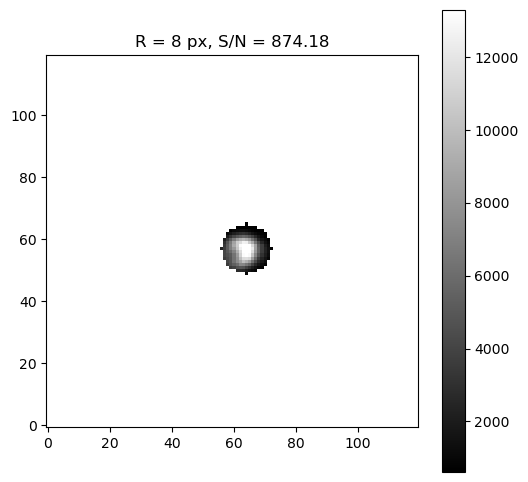

Raggio: 9 px | Flusso: 883200.06 | Errore: 994.10 | S/N: 888.44


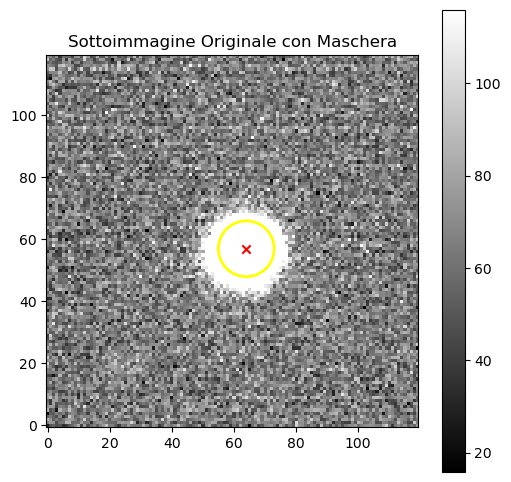

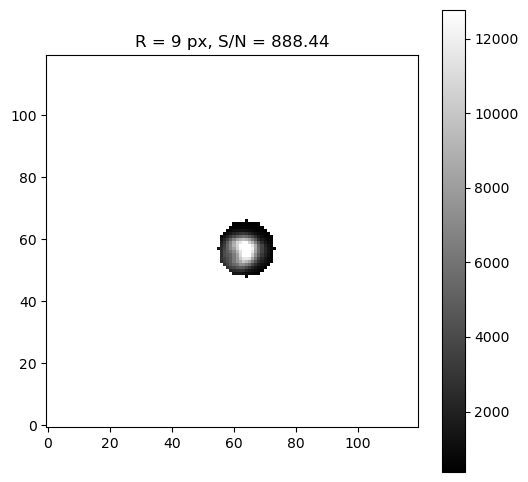

Raggio: 10 px | Flusso: 910980.98 | Errore: 1020.47 | S/N: 892.70


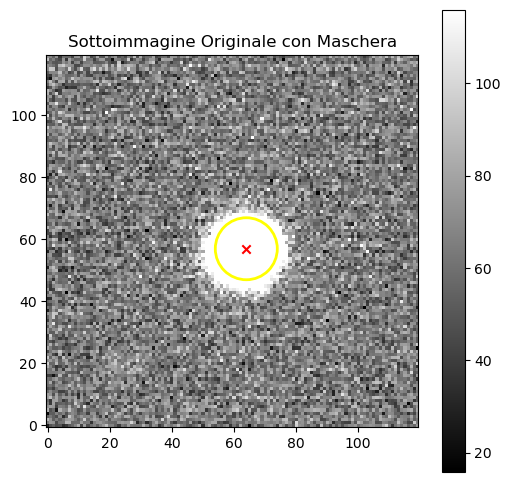

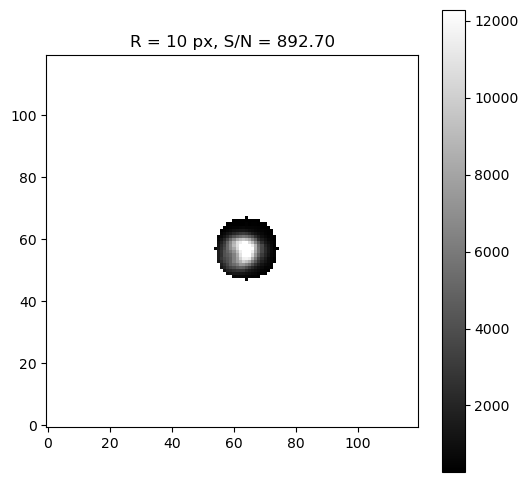

Raggio: 11 px | Flusso: 924651.87 | Errore: 1038.75 | S/N: 890.16


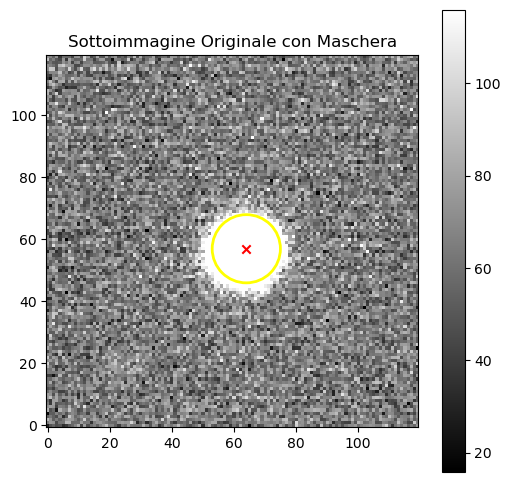

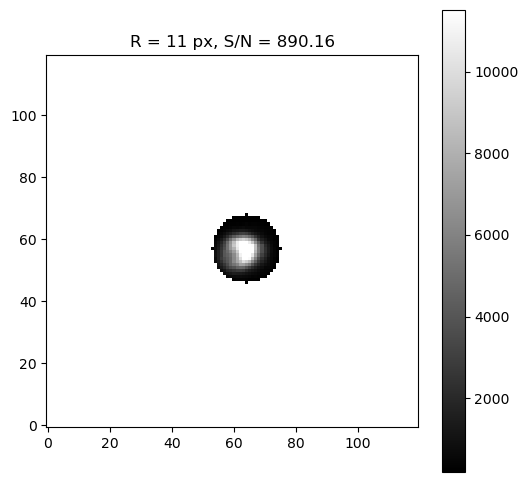

Raggio: 12 px | Flusso: 933237.19 | Errore: 1055.11 | S/N: 884.49


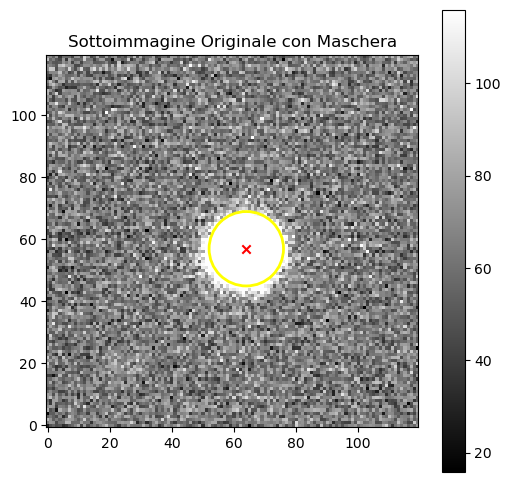

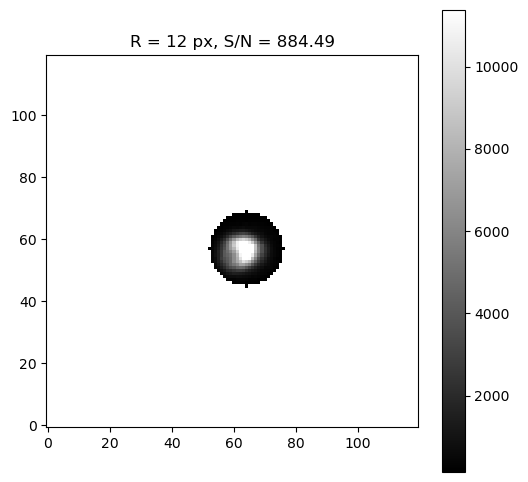

Raggio: 13 px | Flusso: 939332.45 | Errore: 1074.63 | S/N: 874.10


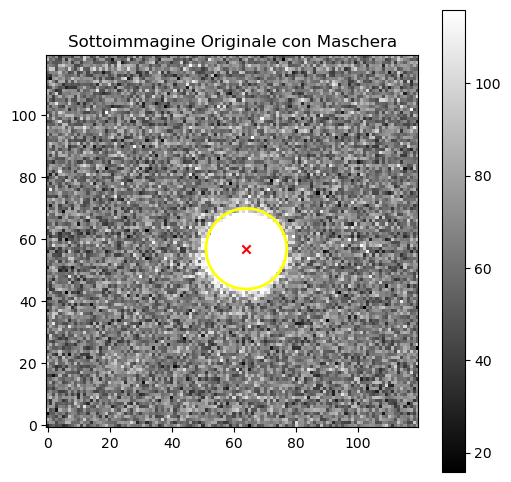

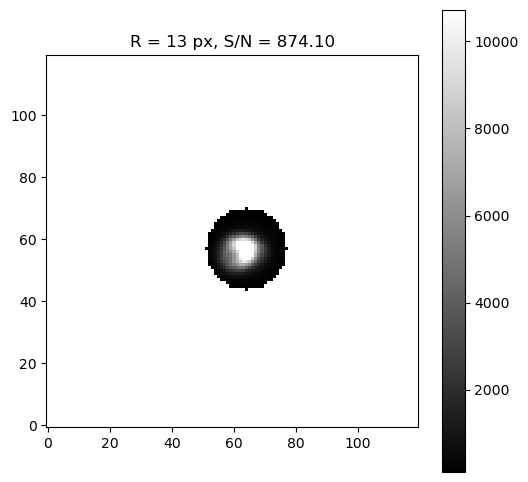

Raggio: 14 px | Flusso: 942653.96 | Errore: 1091.83 | S/N: 863.37


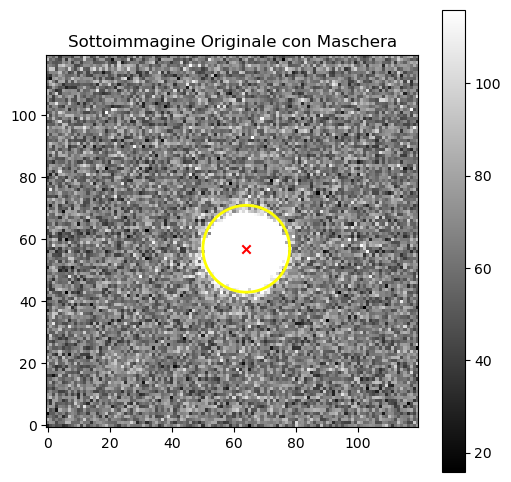

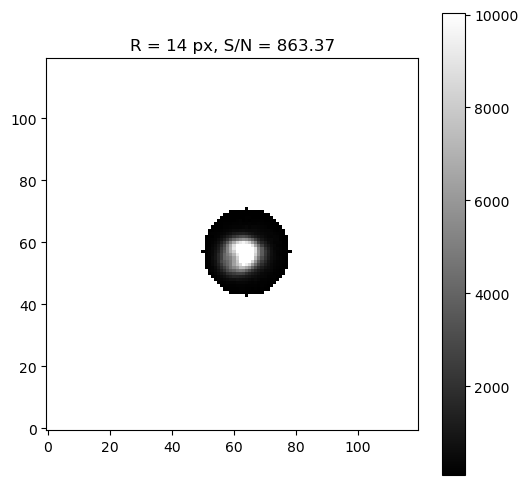

Raggio: 15 px | Flusso: 944756.84 | Errore: 1110.43 | S/N: 850.81


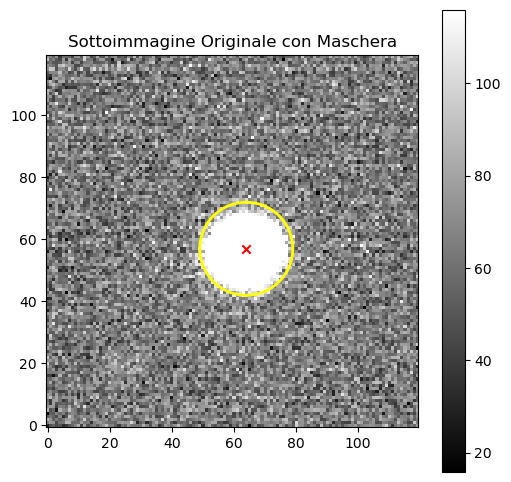

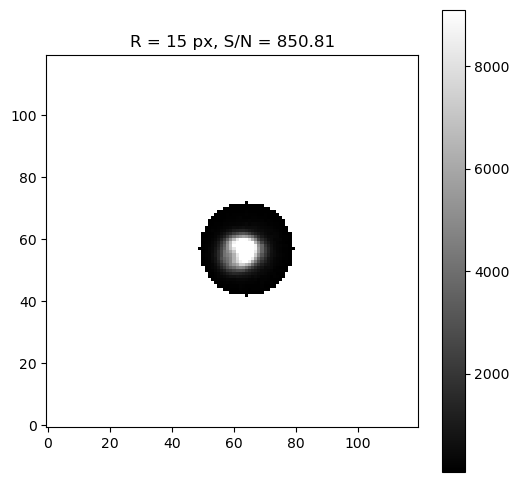

Raggio: 16 px | Flusso: 946080.35 | Errore: 1126.95 | S/N: 839.51


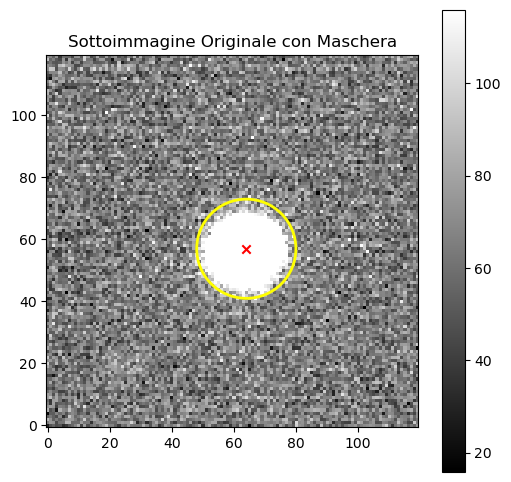

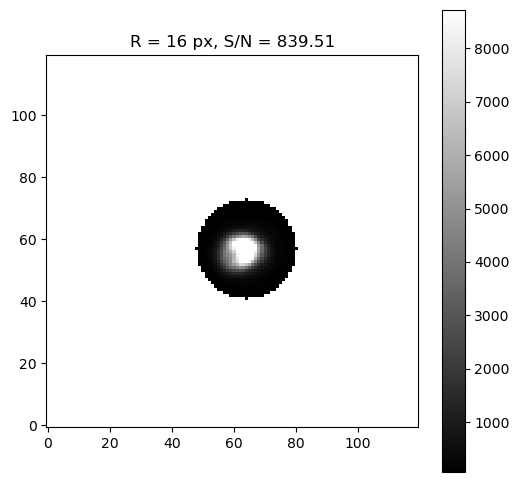

Raggio: 17 px | Flusso: 947057.61 | Errore: 1145.92 | S/N: 826.46


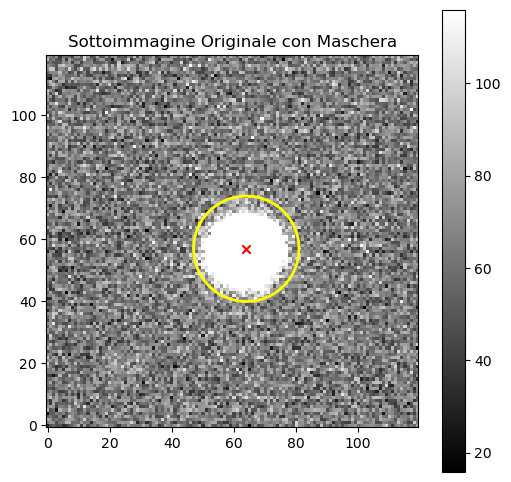

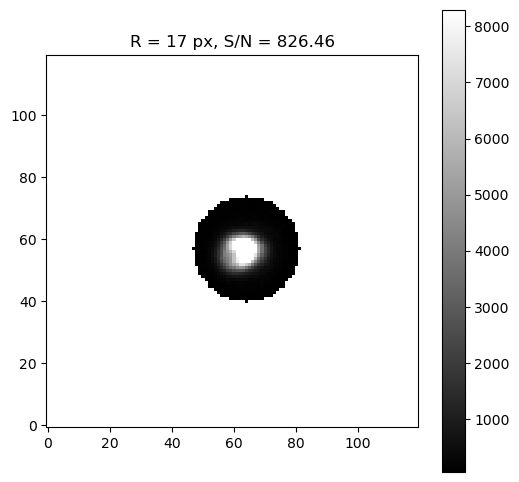

Raggio: 18 px | Flusso: 947906.25 | Errore: 1165.22 | S/N: 813.50


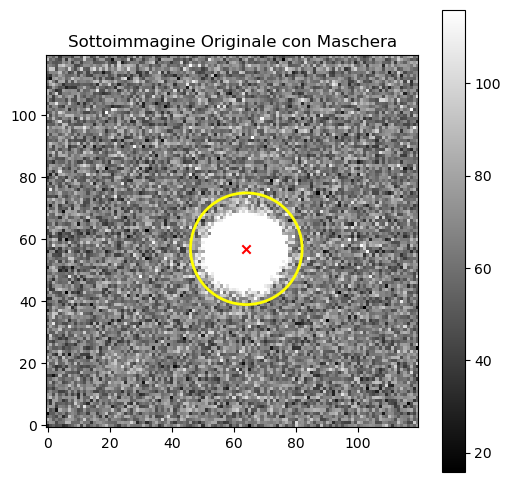

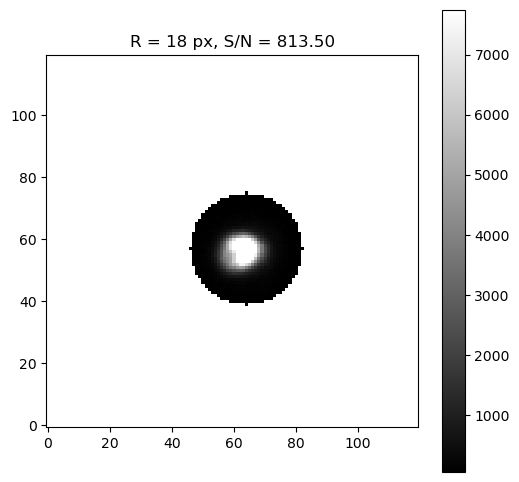

Raggio: 20 px | Flusso: 948844.22 | Errore: 1207.99 | S/N: 785.47


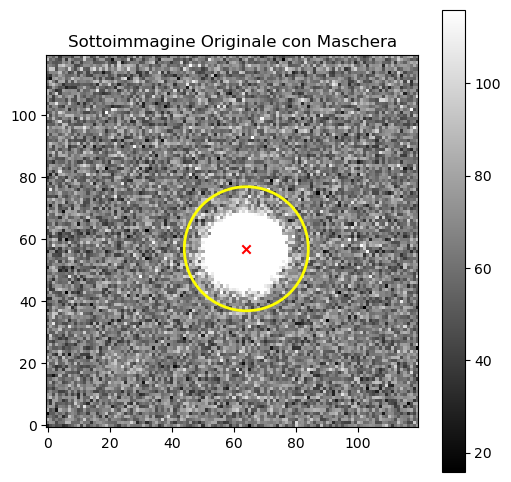

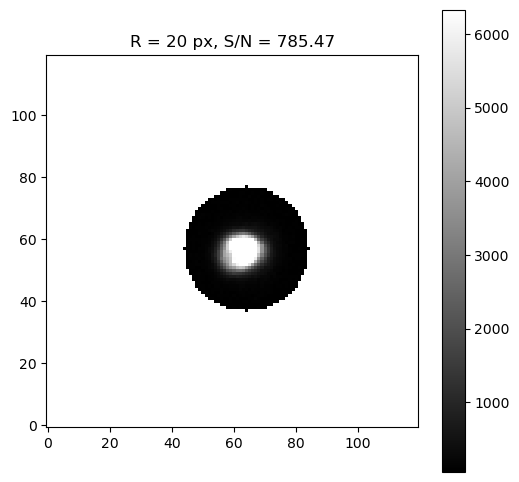

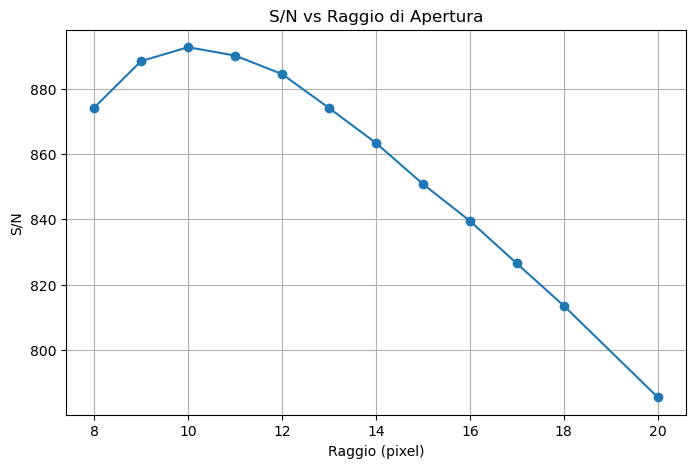

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.patches import Circle

# --- CARICAMENTO DATI ---
def load_reduced_image(filepath):
    # Apre un file FITS e restituisce i dati come array float64
    with fits.open(filepath) as hdul:
        return hdul[0].data.astype(np.float64)

# --- ESTRATTORE DI SOTTOIMMAGINI ---
def extract_subimage(image, x_range, y_range):
    # Estrae una porzione dell'immagine originale
    return image[y_range[0]:y_range[1], x_range[0]:x_range[1]]

# --- COSTRUISCI MASCHERA CIRCOLARE ---
def create_circular_mask(shape, center, radius):
    # Crea una maschera circolare booleana centrata in `center` con raggio `radius`
    rows, cols = np.ogrid[:shape[0], :shape[1]]
    y, x = center
    mask = (rows - y)**2 + (cols - x)**2 <= radius**2
    return mask

# --- FOTOMETRIA DI APERTURA ---
def aperture_photometry(subimage, radius, gain=0.82, read_noise=10):
    # Trova la posizione del massimo, la assumiamo come centro dell'oggetto
    pos_max = np.unravel_index(np.nanargmax(subimage), subimage.shape)
    mask = create_circular_mask(subimage.shape, pos_max, radius)

    # Crea due immagini: una per il target e una per il background
    target = np.copy(subimage)
    bckg = np.copy(subimage)
    target[~mask] = np.nan  # tutto fuori dalla maschera va ignorato
    bckg[mask] = np.nan     # tutto dentro la maschera va ignorato

    # Converte i valori in elettroni
    target_flux = target * gain
    bckg_flux = bckg * gain

    # Flusso oggetto = flusso meno livello di fondo
    object_flux = target_flux - np.nanmean(bckg_flux)

    # Calcolo errore totale (quantità INTEGRATE)
    N_pix = np.sum(mask)
    bkg_mean = np.nanmean(bckg_flux)
    object_err = np.sqrt(
        np.nansum(object_flux) + N_pix * read_noise**2 + 2 * N_pix * (bkg_mean + read_noise**2)
    )   # trascuro dark current perché uso immagini ridotte

    object_flux_int = np.nansum(object_flux)
    snr = object_flux_int / object_err

    return object_flux_int, object_err, snr, pos_max, mask

# --- PLOT RISULTATO DI OGNI FOTOMETRIA ---
def plot_results(subimage, mask, pos_max, snr, radius):
    # Mostra la sottoimmagine originale con la maschera
    plt.figure(figsize=(6, 6))
    plt.title(f"Sottoimmagine Originale con Maschera")
    plt.imshow(subimage, origin='lower', cmap='gray',
               vmin=np.nanmedian(subimage)-50, vmax=np.nanmedian(subimage)+50)
    plt.colorbar()

    # Aggiungi il cerchio della maschera
    circle = Circle((pos_max[1], pos_max[0]), radius, color='yellow', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
    plt.scatter(pos_max[1], pos_max[0], color='red', marker='x')  # Centro con X
    plt.show()

    # Mostra la sottoimmagine con evidenziata la regione usata dalla maschera
    subim_show = np.copy(subimage)
    subim_show[~mask] = np.nan  # non vedo i pixel oltre la maschera

    # Ottimizza il range di visualizzazione
    vmin = np.nanpercentile(subim_show, 5)
    vmax = np.nanpercentile(subim_show, 95)

    plt.figure(figsize=(6, 6))
    plt.title(f"R = {radius} px, S/N = {snr:.2f}")
    plt.imshow(subim_show, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

# --- GRAFICO FINALE S/N vs RAGGIO ---
def plot_snr_vs_radius(radii, snrs):
    plt.figure(figsize=(8, 5))
    plt.plot(radii, snrs, marker='o')
    plt.title("S/N vs Raggio di Apertura")
    plt.xlabel("Raggio (pixel)")
    plt.ylabel("S/N")
    plt.grid(True)
    plt.show()

# --- PROCEDURA COMPLETA ---
def run_aperture_photometry(path, filename, x_range, y_range, radii):
    filepath = os.path.join(path, filename)
    image = load_reduced_image(filepath)
    subimage = extract_subimage(image, x_range, y_range)

    snrs = []  # per il grafico finale
    for radius in radii:
        flux, err, snr, pos, mask = aperture_photometry(subimage, radius)
        print(f"Raggio: {radius} px | Flusso: {flux:.2f} | Errore: {err:.2f} | S/N: {snr:.2f}")
        plot_results(subimage, mask, pos, snr, radius)
        snrs.append(snr)

    plot_snr_vs_radius(radii, snrs)

# --- ESEMPIO DI USO ---
if __name__ == "__main__":
    base_path = '/Users/claudiamurro/Desktop/laboratorio tecnologie astronomiche/cupani/reduced'
    filename = 'SZ_Lyn-0001_reduced.fit'
    x_range = (550, 670)
    y_range = (800, 920)
    radii = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]  # prova diversi raggi

    run_aperture_photometry(base_path, filename, x_range, y_range, radii)